# Advanced Business Analytics (CIS442D)

## Homework Assignment 5 (Optional)
### Due date: 2/20/2017 23:55
### Submission Instructions
1. Each student should submit an individual homework assignment.
2. Discussing solutions with others is allowed.
3. Copying solutions is prohibited.
4. Late submissions will not be accepted.
5. Write your solutions in Jupyter IPython notebooks. Use markdown cells to format your document. Your solutions should be replicable, as it will be executed on the grader's computer.
6. Solution files should be uploaded to Blackboard.
---

# Exercise 1: simple recommendation system

In this homework assignment, you are asked to construct a recommendation system that predicts movie ratings. 

1. Download the data from http://grouplens.org/datasets/movielens/1m/ (the file README contains information about the structure of each of the datafiles)
2. __Create a subset of the data which only contains the movies and users with the largest number of ratings. Use the top 10 users and movies. That is, the number of times the movie has been rated counts, and not the average rating value.__
2. Plot a histogram of the subset data showing the frequency of ratings across all users (that is, how many votes are for rating 1, ratin 2, etc.)
3. Split the subset data randomly to training and test data (you may use the train_test_split function from scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. Use the training data to construct a baseline predictor, which predicts the average movie rating by all users
5. Construct a collaborative filtering predictor. __You may use any similarity measure of your choice__ (you may also use the function DataFrame.corr).
6. Use the test data to measure the prediction accuracy of the two predictors. Explain your choice for the accuracy measure
7. Run the code again, this time with the top 100 users and movies and report on your findings.

Make sure to comment your code.

In [1]:
!ls

_hints_.txt
homework5-Copy1.ipynb
homework5-revised-solution.ipynb
homework5-solution.ipynb
homework5-version2.ipynb
homework5 v2.zip
homework5.ipynb
homework5.zip
movies.dat
old
ratings.dat
README
users.dat
votes.csv


In [2]:
!head -10 movies.dat

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


In [3]:
!head -10 ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
1::2355::5::978824291
1::1197::3::978302268
1::1287::5::978302039
1::2804::5::978300719
1::594::4::978302268
1::919::4::978301368


In [4]:
!head -10 users.dat

1::F::1::10::48067
2::M::56::16::70072
3::M::25::15::55117
4::M::45::7::02460
5::M::25::20::55455
6::F::50::9::55117
7::M::35::1::06810
8::M::25::12::11413
9::M::25::17::61614
10::F::35::1::95370


In [5]:
!cat readme

SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a facult

In [6]:
!wc *.dat

    3883    15675   171308 movies.dat
 1000209  1000209 24594131 ratings.dat
    6040     6040   134368 users.dat
 1010132  1021924 24899807 total


In [1]:
# Read the rating.dat file
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

arr=np.loadtxt('ratings.dat',delimiter='::')
arr[1]

# declare index
index = [i for i in range(1, len(arr)+1)]
# declare column name
column = ['UserID','MovieID','Rating','Timestamp']
df_rating = pd.DataFrame(data=arr[0:,0:],    
             index=index,
             columns = column)


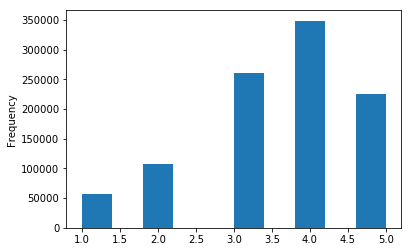

In [2]:
#Plot a histogram of the ratings showing the frequency of ratings across all users 
import matplotlib.pyplot as plt
%matplotlib inline
df_rating["Rating"].plot.hist()

In [3]:
from sklearn.model_selection import train_test_split
# split the data into trainning data and test data
# because of the data size, we only choose 5% data as trainning data
df_train, df_test = train_test_split(df_rating, test_size=0.95)

def base_train(df_train):
    # mean value of rating
    mu = df_train[["Rating"]].mean(axis=0)
    # calculate oberved deviation of movie
    movie_rating = df_train.groupby('MovieID').agg(['mean', 'count','std'])
    bi = ((movie_rating.Rating["mean"]*movie_rating.Rating["count"])-(mu[0]*movie_rating.Rating["count"]))/(25+movie_rating.Rating["count"])
    bi = pd.DataFrame(data = bi, columns = ['bi'])
    df_train = df_train.merge(bi, left_on= "MovieID", right_index=True)
    # calculate oberved deviation of user
    user_rating = df_train.groupby('UserID').agg(['mean', 'count','std'])
    bu = ((user_rating.Rating["mean"]*user_rating.Rating["count"])-(mu[0]*user_rating.Rating["count"])-(user_rating.bi["mean"]*user_rating.bi["count"]))/(10+user_rating.Rating["count"])
    bu = pd.DataFrame(data = bu, columns = ['bu'])
    df_train = df_train.merge(bu, left_on= "UserID", right_index=True)
    # compute the baseline predict result
    df_train['base_predict'] = mu[0] + df_train['bi']+df_train['bu']
    del df_train['bi']
    del df_train['bu']
    
    return df_train['base_predict']


In [9]:
# predict the rating
base_pred = base_train(df_train)

In [4]:
# how many users and movies in the data
n_users = df_rating.UserID.max()
n_items = df_rating.MovieID.max()
print(str(n_users) + ' users')
print(str(n_items) + ' items')

# build a matrix for each user and each movie
ratings = np.zeros((n_users+1, n_items+1))

# the first row is moviesID and first column is userID
# the matrix contain each user rating to each movie
# use the only trainning data
for row in df_train.itertuples():
    ratings[0,row[2]] = row[2]
    ratings[row[1],0] = row[1]
    ratings[row[1], row[2]] = row[3]

6040.0 users
3952.0 items


/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
# convert it to dataframe and substute 0 value with nan
df = pd.DataFrame(ratings[1:,1:],index=ratings[1:,0],columns = ratings[0,1:])
df[df <= 0] = np.nan
df
# calculate the similarity matrix from the above matrix
user_similarity = df.T.corr()
user_similarity

,1.0,2.0,3.0,0.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:

def cf_train(df_train):
    #calculate mean for each user
    user_rating = df_train.groupby('UserID').agg(['mean', 'count','std'])
    user_avg = user_rating.Rating["mean"]
    user_avg = pd.DataFrame(data = user_avg)
    df_train = df_train.merge(user_avg, left_on= "UserID", right_index=True)
    df_train['cf_pred'] = 0
    # iterate the trainning data
    for i in range(0,len(df_train)):
        movie = df_train.iloc[i,1]
        user = df_train.iloc[i,0]
        mean1 = df_train.iloc[i,4]
        # find the users who rate the specific movie
        movie_group = df.loc[:,movie]
        movie_group = movie_group.dropna()
        n = 0
        d = 0
        # for each user who rate the movie
        for j in range(0,len(movie_group)):
            # find similarity
            similarity = user_similarity.loc[(movie_group.index[j]),(user)]
            # if no similarity
            if np.isnan(similarity):
                continue
            # if there is similarity
            else:
                mean2 = user_rating.loc[(movie_group.index[j]),'Rating'][0]
                n = n+(movie_group.iloc[j]-mean2)*similarity
                d = d+similarity
        # if no similar user
        if(d != 0):
            df_train.cf_pred.iloc[i] = n/d+mean1
        # if there is similar users
        else:
            df_train.cf_pred.iloc[i] = mean1
            
    return df_train['cf_pred']


In [7]:
# Predict the ratings
cf_pred = cf_train(df_train)

/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
cf_pred

115338     4.706700
115399     4.103965
115253     5.149384
115474     4.390627
115227     1.677285
115235     4.395833
115302    -0.156649
115555     2.577868
115217     5.204251
115307    -6.043142
115209     4.371465
115569    -1.530760
115445     2.013435
115578     2.203493
115419     4.638889
115322     2.704555
115511     4.000000
115276     0.325843
115265     3.541667
115332     5.442148
115499     3.332978
115634    -6.998764
115243     3.541667
115396     4.000000
635686     4.000000
635625     4.250000
635667     4.000000
635621     4.250000
961864     3.842394
962049   -17.056942
            ...    
625797     3.000000
126155     1.000000
390920     4.000000
399353     4.000000
154066     4.000000
720834     4.000000
333158     4.000000
864477     5.000000
460117     2.000000
597418     2.000000
85926      4.000000
774904     4.000000
808348     1.000000
132816     2.000000
265402     4.000000
701120     4.000000
509187     3.000000
741193     3.000000
569873     3.000000


In [10]:
# I use the mean squared error. Since we are predicting the ratings, which is not a binary variable, 
# we have to calculate the distance between our predict value and the actual value. So mean squared error is a
# proper metric to measure the accuracy.

from sklearn.metrics import mean_squared_error
print('baseline MSE: '+ str(mean_squared_error(base_pred,df_train['Rating'])))
print('CF MSE: '+ str(mean_squared_error(cf_pred,df_train['Rating'])))

# The difference between the two filter is that we consider about the similarity between users. In baseline MSE, we 
# consider each user equal to the predicting user by using mean. However, for CF, we only consider about the user who
# rate the same movie. This give us more confident about our predicting result.

baseline MSE: 1.42821192592
CF MSE: 1.09221031411e+30


# Exercise 2: PageRank
Based on Chapter 11 in "The analytics edge" by Bertsimas et al. 
Data source: https://www.dynamic-ideas.com/Books/0989910897/anedge.html

The file  "votes.csv" contains the voting preferences of an executive board on the new CEO. Use the PageRank algorithm to rank the candidates according to the votes. You can think about each person as a node, and each vote as an arc from one person to another.
1. After how many iterations did the algorithm converge? explain.
2. Plot a graph representing the voting preferences (who votes for who).
3. Rank the candidates (display the result of PageRank).
4. Rank the candidates based on the total number of votes each candidate received.
5. Explain the differences in the final rankings created by the two methods.

# Optional coding assignment
This is an __optional__ exercise, which will be graded and counted towards the class participation component of your grade (it could only improve your grade).

Read the first chapter in https://automatetheboringstuff.com/chapter3/ and solve the practice quetsions appearing at the end of the chapter.

In [ ]:
# Solution to Q1

In [ ]:
# Solution to Q2

In [ ]:
# Solution to Q3

In [ ]:
# Solution to Q4

In [ ]:
# Solution to Q5

In [ ]:
# Solution to Q6

In [ ]:
# Solution to Q7

In [ ]:
# Solution to Q8

In [ ]:
# Solution to Q9

In [ ]:
# Solution to Q10

In [ ]:
# Solution to Q11

In [ ]:
# Solution to Q12

In [ ]:
# Solution to Q13

In [ ]:
# Solution to Q14

In [ ]:
# Solution to practice project: The Collatz Sequence

In [ ]:
# Solution to practice project: Input Validation